# Project Proposal: Group 34

In [164]:
#Load necessary packages for the project proposal
library(tidyverse)
library(repr)
library(infer)
library(cowplot)

In [165]:
#Load data into R frame, note that the dataset below only applies to math course
student_data_original <- read_delim(file = "https://raw.githubusercontent.com/czhang176/dsci100_groupproject/main/student-mat.csv",
                           delim = ";") 

#filter out columns other than G1, G2, G3, and schoolsup, then filter out the NA rows if applicable, also add in final_grade_by_percent to
#represent students overall performance on the course
student_data_clean <- student_data_original %>%
                      select(school, G1, G2, G3, schoolsup) %>%
                      filter(G1 != is.na(G1) & G2 != is.na(G2) & G3 != is.na(G3) & schoolsup != is.na(schoolsup)) %>%
                      mutate(final_grade_by_percent = (G3) / 20 * 100) %>%
                      rename(period_1_grade = G1, period_2_grade = G2, final_grade = G3, extra_edu_support = schoolsup)

student_data_clean

Rows: 395 Columns: 33

── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (17): school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardi...
dbl (16): age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



school,period_1_grade,period_2_grade,final_grade,extra_edu_support,final_grade_by_percent
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
GP,5,6,6,yes,30
GP,5,5,6,no,30
GP,7,8,10,yes,50
GP,15,14,15,no,75
GP,6,10,10,no,50
GP,15,15,15,no,75
GP,12,12,11,no,55
GP,6,5,6,yes,30
GP,16,18,19,no,95


## Bootstrap Samples for Students with Edu Support and without Edu Support

In [166]:
set.seed(8622) # ensure the result produced is reproducible on every run
#first split the data into with edu support & without edu support
students_with_support <- student_data_clean %>%
                         filter(extra_edu_support == "yes")
#A TA said that best to keep samples with the same data size so trim down the sample size for students_without_support
#Note: try explaining here why we need to ensure two samples have the same size & why we decide to trim down not scale up
students_without_support <- student_data_clean %>%
                           filter(extra_edu_support == "no") %>%
                           rep_sample_n(reps = 1, size = nrow(students_with_support), replace = FALSE) %>%
                           ungroup() %>%
                           select(-replicate)

## Comments on School Variable:

samples,mean,median,standard_deviation
<chr>,<dbl>,<dbl>,<dbl>
MP,51.00000,52.5,16.12452
GP,53.11111,50.0,16.49954


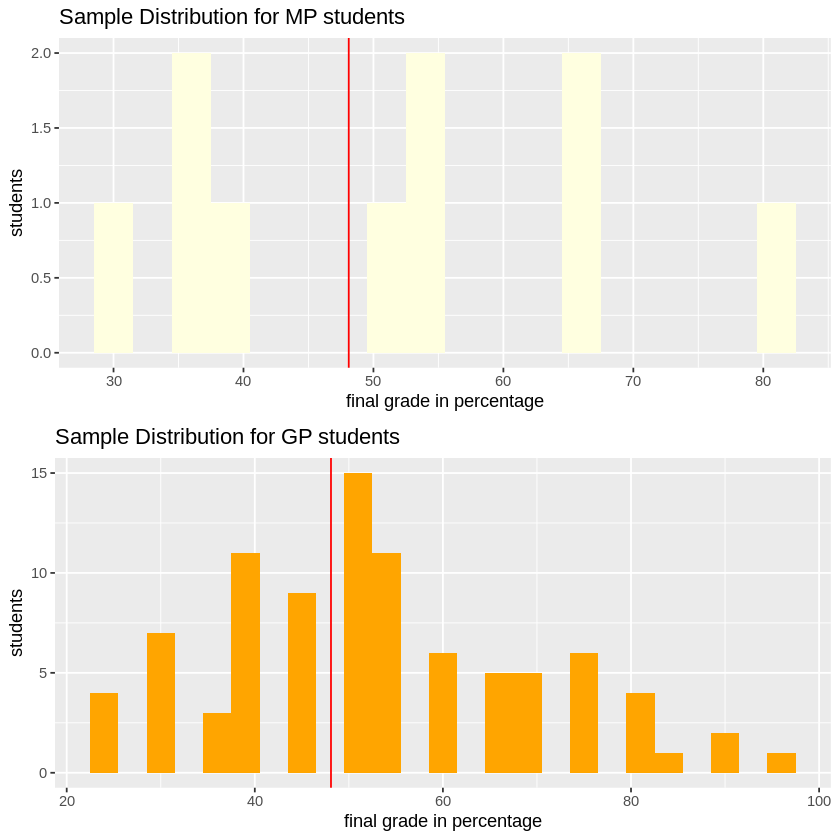

In [167]:
#data set below rebinds all the observations will be used for our hypothesis testing so that we can see the effect of school variable on final grade by percent
total_observations_used <- rbind(students_with_support, students_without_support)
MS_students <- total_observations_used %>%
               filter(school == "MS")
GP_students <- total_observations_used %>%
               filter(school == "GP")
MS_students_stats <- MS_students %>%
                     summarize(mean = mean(final_grade_by_percent), median = median(final_grade_by_percent), sd = sd(final_grade_by_percent))
MS_mean <- MS_students_stats %>%
           pull(mean) %>%
           as.numeric()
MS_median <- MS_students_stats %>%
             pull(median) %>%
             as.numeric()
MS_sd <- MS_students_stats %>%
         pull(sd) %>%
         as.numeric()
GP_students_stats <- GP_students %>%
                     summarize(mean = mean(final_grade_by_percent), median = median(final_grade_by_percent), sd = sd(final_grade_by_percent))
GP_mean <- GP_students_stats %>%
           pull(mean) %>%
           as.numeric()
GP_median <- GP_students_stats %>%
             pull(median) %>%
             as.numeric()
GP_sd <- GP_students_stats %>%
         pull(sd) %>%
         as.numeric()

# Construct a table to compare their stats
sample_estimates_table_final_grade_by_percent_schools <- data.frame(samples = c("MP", "GP"),
                                                         mean = c(MS_mean, GP_mean),
                                                         median = c(MS_median, GP_median),
                                                         standard_deviation = c(MS_sd, GP_sd))
sample_estimates_table_final_grade_by_percent_schools

# Visualisation:
MS_students_plot <-  MS_students %>%
                     ggplot(aes(x = final_grade_by_percent)) +
                     geom_histogram(binwidth = 3, fill = "lightyellow") +
                     geom_vline(xintercept = mean_final_with_support, colour = "red") +
                     xlab("final grade in percentage") +
                     ylab("students") +
                     ggtitle("Sample Distribution for MP students")

GP_students_plot <-  GP_students %>%
                     ggplot(aes(x = final_grade_by_percent)) +
                     geom_histogram(binwidth = 3, fill = "orange") +
                     geom_vline(xintercept = mean_final_with_support, colour = "red") +
                     xlab("final grade in percentage") +
                     ylab("students") +
                     ggtitle("Sample Distribution for GP students")
plot_grid(MS_students_plot, GP_students_plot, ncol = 1)

#Thus we fliter this variable out because their sample distributions resemble each other & they have very similar average score.

## Table of Statistics for Variables of Interest 
the code below should provide tables containing mean, sd, median for variables G1, G2, G3, and final_grade_by_percent.

In [168]:
#sample estimates for variable: final_grade_by_percent
final_with_support_stats <- students_with_support %>%
                           summarize(mean = mean(final_grade_by_percent), median = median(final_grade_by_percent), sd = sd(final_grade_by_percent))
mean_final_with_support <- final_with_support_stats %>%
                           pull(mean) %>%
                           as.numeric()
median_final_with_support <- final_with_support_stats %>%
                             pull(median) %>%
                             as.numeric()
sd_final_with_support <- final_with_support_stats %>%
                         pull(sd) %>%
                         as.numeric()

final_without_support_stats <- students_without_support %>%
                           summarize(mean = mean(final_grade_by_percent), median = median(final_grade_by_percent), sd = sd(final_grade_by_percent))
mean_final_without_support <- final_without_support_stats %>%
                              pull(mean) %>%
                              as.numeric()
median_final_without_support <- final_without_support_stats %>%
                                pull(median) %>%
                                as.numeric()
sd_final_without_support <- final_without_support_stats %>%
                            pull(sd) %>%
                            as.numeric()
#construct a table for sample estimates of population parameters:
sample_estimates_table_final_grade_by_percent <- data.frame(samples = c("students_with_support", "students_without_support"),
                                                            mean = c(mean_final_with_support, mean_final_without_support),
                                                            median = c(median_final_with_support, mean_final_without_support),
                                                            standard_deviation = c(sd_final_with_support, sd_final_without_support))
sample_estimates_table_final_grade_by_percent

samples,mean,median,standard_deviation
<chr>,<dbl>,<dbl>,<dbl>
students_with_support,48.1,50.0,12.77314
students_without_support,57.7,57.7,18.24465


## Bootstrap Sampling & 95% Confidence Interval for final_grade_by_percent

In [169]:
#remember the null hypothesis here:
#the average (mean) performance of students with edu support and without edu support are the same.
#bootstrapping sampling:
#n here refers to the number of bootstrap samples we will take from the sample
n = 10000
#bootstrap sampling distribution for students with edu support
students_with_support_bootstrap_sample <- students_with_support %>%
                                          rep_sample_n(reps = n, size = nrow(students_with_support), replace = TRUE) %>%
                                          group_by(replicate) %>%
                                          summarize(mean = mean(final_grade_by_percent))

students_without_support_bootstrap_sample <- students_without_support %>%
                                          rep_sample_n(reps = n, size = nrow(students_with_support), replace = TRUE) %>%
                                          group_by(replicate) %>%
                                          summarize(mean = mean(final_grade_by_percent))

#Construct Confidence Interval:for students without financial support: use 95% now
upper_quantile <- students_without_support_bootstrap_sample %>% 
                  pull(mean) %>% 
                  quantile(0.975)
lower_quantile <- students_without_support_bootstrap_sample %>% 
                  pull(mean) %>% 
                  quantile(0.025)

## Sampling & Visualization for final_grade_by_percent
since the data obtained is not huge, we will take the entire data as a sample to perform bootstrapping and confidence interval

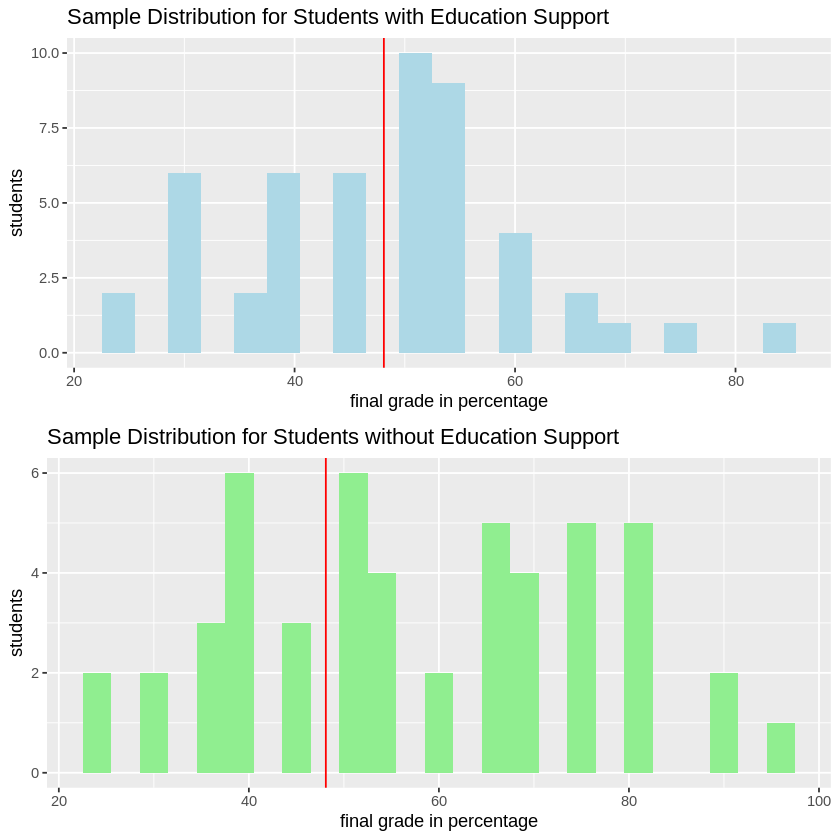

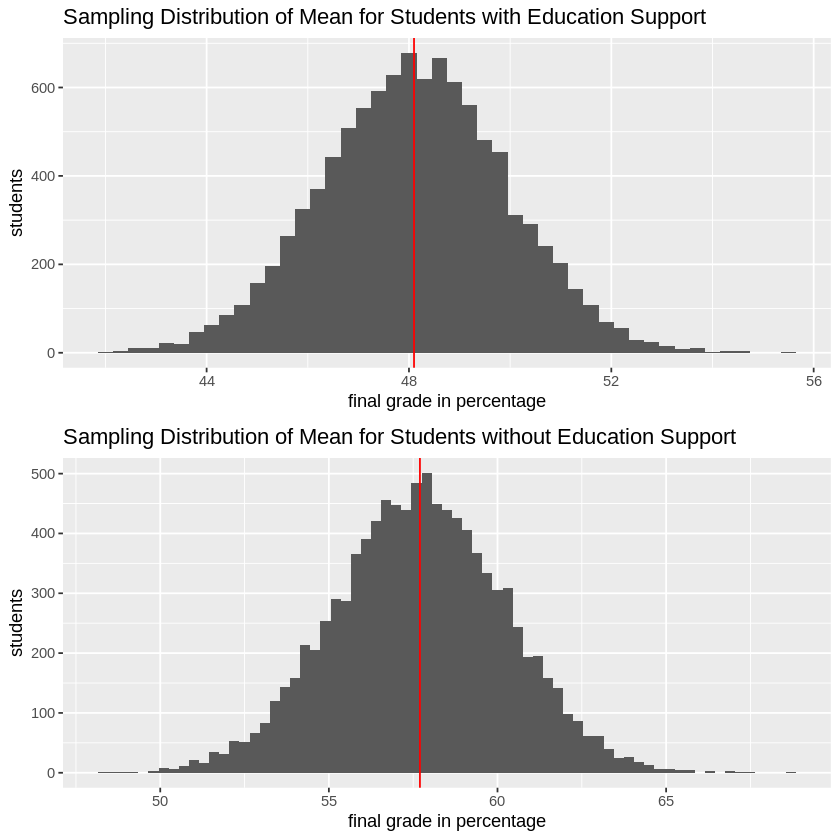

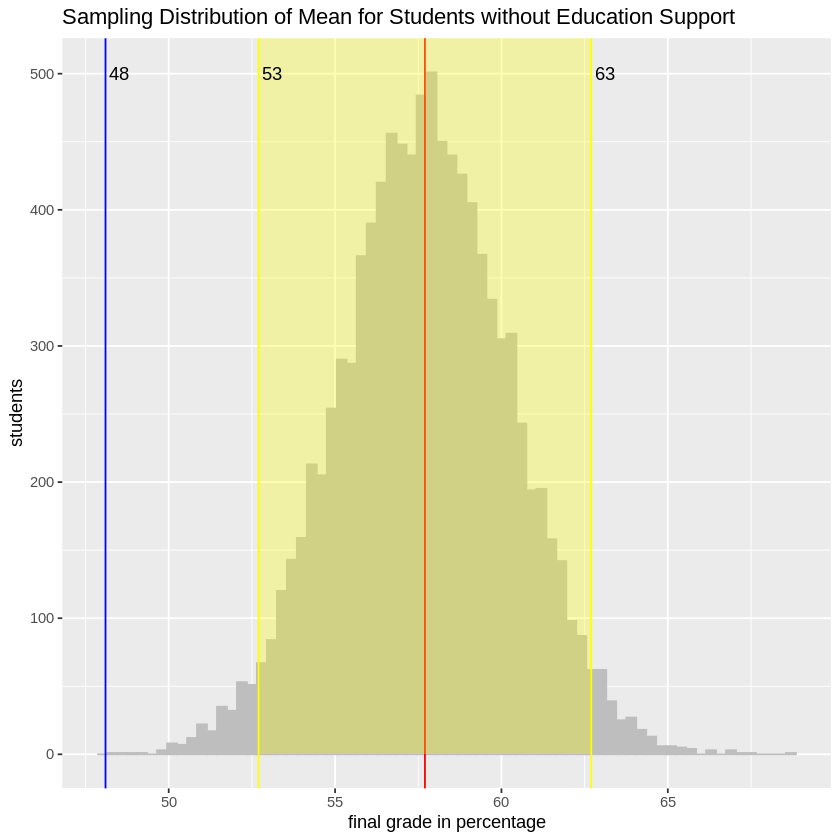

In [170]:
#sample distribution:
student_with_support_plot <-  students_with_support %>%
                              ggplot(aes(x = final_grade_by_percent)) +
                              geom_histogram(binwidth = 3, fill = "lightblue") +
                              geom_vline(xintercept = mean_final_with_support, colour = "red") +
                              xlab("final grade in percentage") +
                              ylab("students") +
                              ggtitle("Sample Distribution for Students with Education Support")

student_without_support_plot <-  students_without_support %>%
                              ggplot(aes(x = final_grade_by_percent)) +
                              geom_histogram(binwidth = 3, fill = "lightgreen") +
                              geom_vline(xintercept = mean_final_with_support, colour = "red") +
                              xlab("final grade in percentage") +
                              ylab("students") +
                              ggtitle("Sample Distribution for Students without Education Support")

plot_grid(student_with_support_plot, student_without_support_plot, ncol = 1)

#bootstrap sampling distribution visualisation:
students_with_support_boostraping_sampling_distribution_plot <- students_with_support_bootstrap_sample %>%
                                                                ggplot(aes(x = mean)) +
                                                                geom_histogram(binwidth = 0.3) +
                                                                geom_vline(xintercept = mean_final_with_support, colour = "red") +
                                                                xlab("final grade in percentage") +
                                                                ylab("students") +
                                                                ggtitle("Sampling Distribution of Mean for Students with Education Support")
students_without_support_boostraping_sampling_distribution_plot <- students_without_support_bootstrap_sample %>%
                                                                ggplot(aes(x = mean)) +
                                                                geom_histogram(binwidth = 0.3) +
                                                                geom_vline(xintercept = mean_final_without_support, colour = "red") +
                                                                xlab("final grade in percentage") +
                                                                ylab("students") +
                                                                ggtitle("Sampling Distribution of Mean for Students without Education Support")

plot_grid(students_with_support_boostraping_sampling_distribution_plot, students_without_support_boostraping_sampling_distribution_plot, ncol = 1)

students_without_support_boostraping_sampling_distribution_plot_with_ci <- students_without_support_bootstrap_sample %>%
                                                                           ggplot(aes(x = mean)) +
                                                                           geom_histogram(binwidth = 0.3, color = "grey", fill = "grey") +
                                                                           geom_vline(xintercept = mean_final_without_support, colour = "red") +
                                                                           geom_vline(xintercept = mean_final_with_support, colour = "blue") +
                                                                           geom_vline(xintercept = upper_quantile, colour = "yellow") +
                                                                           geom_vline(xintercept = lower_quantile, colour = "yellow") +
                                                                           annotate("rect", xmin = lower_quantile, xmax = upper_quantile, ymin = 0, ymax = Inf,
                                                                                     fill = "yellow",
                                                                                     alpha = 0.3) +
                                                                           annotate("text", x = lower_quantile + 0.1, y = 500, hjust = 0,
                                                                                     label = paste(round(lower_quantile))) +
                                                                           annotate("text", x = upper_quantile + 0.1, y = 500, hjust = 0,
                                                                                     label = paste(round(upper_quantile))) +
                                                                           annotate("text", x = mean_final_with_support + 0.1, y = 500, hjust = 0,
                                                                                     label = paste(round(mean_final_with_support))) +
                                                                           xlab("final grade in percentage") +
                                                                           ylab("students") +
                                                                           ggtitle("Sampling Distribution of Mean for Students without Education Support")
students_without_support_boostraping_sampling_distribution_plot_with_ci
                                                            



## Results:
Students with financial support does a lot worse than those who without. 

In [ ]:
# for the results:
# 1. State if the null hypothesis should be rejected, and how confident are we to this result
# 2. limtations: 1. what problems may arise from the methodology 2. is there a way to mitigate these limitations